In [1]:
import h5py
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import seaborn as sns
import scipy as sp

In [10]:
vpr6_0001 = "../../SLEAP/vid_501b/temp-12062021143912-0000.v000.analysis.h5"
vpr6_001 = "../../SLEAP/vid_501b/temp-12062021144739-0000.mp4.predictions.analysis.h5"
vpr6_01 = "../../SLEAP/vid_501b/temp-12062021152724-0000.mp4.predictions.analysis.h5"


HEAD_INDEX = 0
THORAX_INDEX = 1
WING_L_INDEX = 2
WING_R_INDEX = 3

In [11]:

def get_data(filename):
    with h5py.File(filename, "r") as f:
        dset_names = list(f.keys())
        locations = f["tracks"][:].T
        node_names = [n.decode() for n in f["node_names"][:]]
        
    return dset_names, locations, node_names

In [12]:
def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)
    return Y

In [22]:

dset_names, locations, node_names = get_data(vpr6_001)
locations = fill_missing(locations)


In [14]:
def get_angle(head, thorax, wing):
    ## get angle between head and wing via thorax
    
    body_axis = head - thorax 
    wing_axis = wing - thorax

    cosine_angle = np.dot(body_axis, wing_axis) / (np.linalg.norm(body_axis) * np.linalg.norm(wing_axis))
    angle = np.arccos(cosine_angle)

    return 180-np.degrees(angle)


In [15]:
head_loc = locations[:, HEAD_INDEX, :]
thorax_loc = locations[:, THORAX_INDEX, :]
wing_r_loc = locations[:, WING_R_INDEX, :]
wing_l_loc = locations[:, WING_L_INDEX, :]

left_ang = []
right_ang = []

for i  in range(thorax_loc.shape[0]):
    
    left_ang.append(get_angle(head_loc[i].T[0], thorax_loc[i].T[0], wing_l_loc[i].T[0]))
    right_ang.append(get_angle(head_loc[i].T[0], thorax_loc[i].T[0], wing_r_loc[i].T[0]))
               

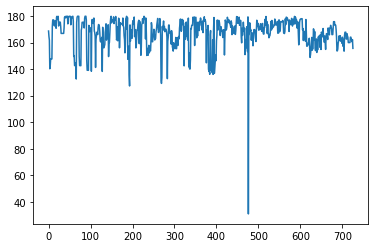

In [20]:
#plt.plot(np.array(left_ang))
plt.plot(180-np.array(right_ang))